In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats

import ncar_jobqueue
from dask.distributed import Client
import cmocean

Note: this notebook uses means over the 5th IAF cycle.

These means were made using this notebook:
/glade/u/home/kristenk/besome/alk_calc_paper/make_5th_IAF_mean.ipynb

#### get DIC control

In [6]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'

In [7]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_DIC.nc'
ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

#### get DIC noGCB

In [8]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_DIC_ALT_CO2.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [9]:
ds['DIC_noGCB'] = ds_tmp['DIC_ALT_CO2']

#### get DIC with 2x GCB

In [10]:
case='cesm22cocco.G1850ECOIAF.T62_g17.004'

In [11]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_DIC_ALT_CO2.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [12]:
ds['DIC_2xGCB'] = ds_tmp['DIC_ALT_CO2']

#### get DIC with 100m dissolution length scale

In [13]:
case='cesm22cocco.G1850ECOIAF.T62_g17.009'

In [14]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_DIC_ALT_CO2.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [15]:
ds['DIC_100mDLS'] = ds_tmp['DIC_ALT_CO2']

### get DIC with 1000m dissolution 

In [16]:
case='cesm22cocco.G1850ECOIAF.T62_g17.010'

In [17]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_DIC_ALT_CO2.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [18]:
ds['DIC_1000mDLS'] = ds_tmp['DIC_ALT_CO2']

#### get CaCO3_FLUX_IN for control

In [19]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'

In [20]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_CaCO3_FLUX_IN.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [21]:
ds['CaCO3_FLUX_IN'] = ds_tmp['CaCO3_FLUX_IN']

#### calculate CaCO3 flux for noGCB and 2xGCB experiments

In [22]:
zero_flux = ds.CaCO3_FLUX_IN * 0.
x2_flux = ds.CaCO3_FLUX_IN * 2.

In [23]:
noGCBflux = zero_flux.where(ds.TLAT<=-30.)
npnoGCBflux = np.asarray(noGCBflux)
x2GCBflux = x2_flux.where(ds.TLAT<=-30.)
npx2GCBflux = np.asarray(x2GCBflux)

In [24]:
npflux = np.asarray(ds['CaCO3_FLUX_IN'].copy())

In [25]:
npflux[~np.isnan(npnoGCBflux)] = npnoGCBflux[~np.isnan(npnoGCBflux)]

In [26]:
ds['CaCO3_FLUX_IN_noGCB'] = (('z_t','nlat','nlon'), npflux)

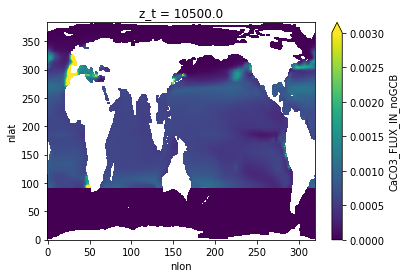

In [27]:
ds['CaCO3_FLUX_IN_noGCB'].isel(z_t=10).plot(vmin=0,vmax=0.003)

In [28]:
npflux = np.asarray(ds['CaCO3_FLUX_IN'].copy())

In [29]:
npflux[~np.isnan(npx2GCBflux)] = npx2GCBflux[~np.isnan(npx2GCBflux)]

In [30]:
ds['CaCO3_FLUX_IN_2xGCB'] = (('z_t','nlat','nlon'), npflux)

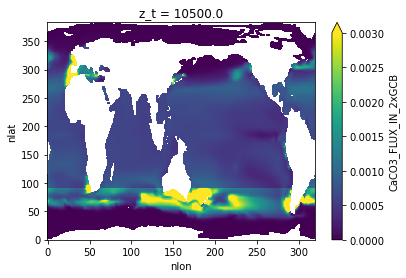

In [31]:
ds['CaCO3_FLUX_IN_2xGCB'].isel(z_t=10).plot(vmin=0,vmax=0.003)

#### get CaCO3_ALT_CO2_FLUX_IN for DLS experiments

In [32]:
case='cesm22cocco.G1850ECOIAF.T62_g17.009'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_CaCO3_ALT_CO2_FLUX_IN.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
ds['CaCO3_FLUX_IN_100mDLS'] = ds_tmp['CaCO3_ALT_CO2_FLUX_IN']

In [33]:
case='cesm22cocco.G1850ECOIAF.T62_g17.010'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_CaCO3_ALT_CO2_FLUX_IN.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
ds['CaCO3_FLUX_IN_1000mDLS'] = ds_tmp['CaCO3_ALT_CO2_FLUX_IN']

#### get POC flux in from control (does not change for experiments)

In [34]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_POC_FLUX_IN.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
ds['POC_FLUX_IN'] = ds_tmp['POC_FLUX_IN']

### Now we have everything we need

In [35]:
#ds

### get WOA for proper coords

In [36]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = ds.z_t

In [37]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
area_m=ds_woa.TAREA * 1e-4
depths_m=ds_woa.z_t * 0.01
dz=ds_woa.dz
dz_m=ds_woa.dz * 0.01

### Total up DIC control

In [38]:
%%time
glb_DIC = esmlab.weighted_sum(ds.DIC, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
glb_DIC = esmlab.weighted_sum(glb_DIC, weights=dz_m, dim=['z_t']).compute()
#dims: none
glb_DIC = glb_DIC.values * 0.001 * 1.e-15 #mmol to Pmol
glb_DIC

CPU times: user 70.7 ms, sys: 144 ms, total: 215 ms
Wall time: 248 ms


3056.356882270227

### Total up DIC noGCB

In [39]:
%%time
glb_DIC_noGCB = esmlab.weighted_sum(ds.DIC_noGCB, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
glb_DIC_noGCB = esmlab.weighted_sum(glb_DIC_noGCB, weights=dz_m, dim=['z_t']).compute()
#dims: none
glb_DIC_noGCB = glb_DIC_noGCB.values * 0.001 * 1.e-15 #mmol to Pmol
glb_DIC_noGCB 

CPU times: user 112 ms, sys: 183 ms, total: 295 ms
Wall time: 330 ms


3060.6609126020817

### Total up DIC 2xGCB

In [40]:
%%time
glb_DIC_2xGCB = esmlab.weighted_sum(ds.DIC_2xGCB, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
glb_DIC_2xGCB = esmlab.weighted_sum(glb_DIC_2xGCB, weights=dz_m, dim=['z_t']).compute()
#dims: none
glb_DIC_2xGCB = glb_DIC_2xGCB.values * 0.001 * 1.e-15 #mmol to Pmol
glb_DIC_2xGCB 

CPU times: user 84.6 ms, sys: 160 ms, total: 244 ms
Wall time: 287 ms


3052.0312412321123

### Total up DIC 100m DLS

In [41]:
%%time
glb_DIC_100mDLS = esmlab.weighted_sum(ds.DIC_100mDLS, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t, time
glb_DIC_100mDLS = esmlab.weighted_sum(glb_DIC_100mDLS, weights=dz_m, dim=['z_t']).compute()
#dims: time
glb_DIC_100mDLS = glb_DIC_100mDLS.values * 0.001 * 1.e-15 #mmol to Pmol
glb_DIC_100mDLS

CPU times: user 84.7 ms, sys: 176 ms, total: 260 ms
Wall time: 300 ms


3058.9993245975666

### Total up DIC 1000m DLS

In [42]:
%%time
glb_DIC_1000mDLS = esmlab.weighted_sum(ds.DIC_1000mDLS, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t, time
glb_DIC_1000mDLS = esmlab.weighted_sum(glb_DIC_1000mDLS, weights=dz_m, dim=['z_t']).compute()
#dims: time
glb_DIC_1000mDLS = glb_DIC_1000mDLS.values * 0.001 * 1.e-15 #mmol to Pmol
glb_DIC_1000mDLS 

CPU times: user 102 ms, sys: 150 ms, total: 251 ms
Wall time: 308 ms


3055.0663984876815

### Calculate Rain ratio at 100m for each experiment

In [43]:
rain_ratio = ds.CaCO3_FLUX_IN.isel(z_t=10)/ds.POC_FLUX_IN.isel(z_t=10)

In [44]:
rain_ratio_mean = esmlab.weighted_mean(rain_ratio, weights=area_m, dim=['nlat', 'nlon']).compute()
rain_ratio_mean = rain_ratio_mean.values
rain_ratio_mean

array(0.14897067)

In [45]:
rain_ratio_noGCB = ds.CaCO3_FLUX_IN_noGCB.isel(z_t=10)/ds.POC_FLUX_IN.isel(z_t=10)

In [46]:
rain_ratio_noGCB_mean = esmlab.weighted_mean(rain_ratio_noGCB, weights=area_m, dim=['nlat', 'nlon']).compute()
rain_ratio_noGCB_mean = rain_ratio_noGCB_mean.values
rain_ratio_noGCB_mean

array(0.1090291)

In [47]:
rain_ratio_2xGCB = ds.CaCO3_FLUX_IN_2xGCB.isel(z_t=10)/ds.POC_FLUX_IN.isel(z_t=10)

In [48]:
rain_ratio_2xGCB_mean = esmlab.weighted_mean(rain_ratio_2xGCB, weights=area_m, dim=['nlat', 'nlon']).compute()
rain_ratio_2xGCB_mean = rain_ratio_2xGCB_mean.values
rain_ratio_2xGCB_mean

array(0.18891223)

In [49]:
rain_ratio_100mDLS = ds.CaCO3_FLUX_IN_100mDLS.isel(z_t=10)/ds.POC_FLUX_IN.isel(z_t=10)

In [50]:
rain_ratio_100mDLS_mean = esmlab.weighted_mean(rain_ratio_100mDLS, weights=area_m, dim=['nlat', 'nlon']).compute()
rain_ratio_100mDLS_mean = rain_ratio_100mDLS_mean.values
rain_ratio_100mDLS_mean

array(0.13403705)

In [51]:
rain_ratio_1000mDLS = ds.CaCO3_FLUX_IN_1000mDLS.isel(z_t=10)/ds.POC_FLUX_IN.isel(z_t=10)

In [52]:
rain_ratio_1000mDLS_mean = esmlab.weighted_mean(rain_ratio_1000mDLS, weights=area_m, dim=['nlat', 'nlon']).compute()
rain_ratio_1000mDLS_mean = rain_ratio_1000mDLS_mean.values
rain_ratio_1000mDLS_mean

array(0.15156476)

In [58]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

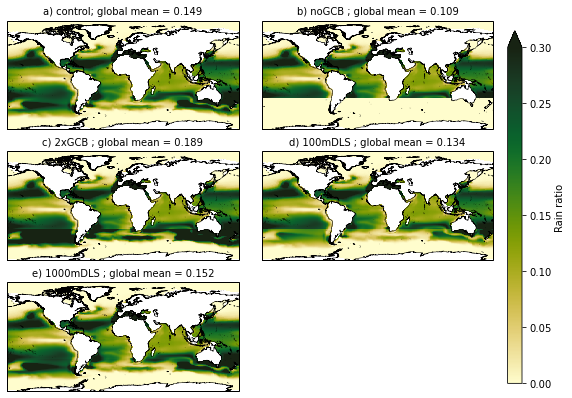

In [62]:
fig = plt.figure(figsize=(10,7))
#plt.suptitle('Rain ratio, Sarmiento et al., 2002 method: GLODAP and CESM', fontsize=14)

#---- CESM  control
ax = fig.add_subplot(3,2,1, projection=ccrs.PlateCarree())
ax.set_title('a) control; global mean = 0.149', fontsize=10,x=0.5, y=1)
ax.coastlines('10m',linewidth=0.5)
lon,lat,field=adjust_pop_grid(lons, lats, rain_ratio)
pc2=ax.pcolormesh(lon, lat, field, vmin=0, vmax=0.3, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())

#---- CESM noGCB
ax = fig.add_subplot(3,2,2, projection=ccrs.PlateCarree())
ax.set_title('b) noGCB ; global mean = 0.109', fontsize=10,x=0.5, y=1)
ax.coastlines('10m',linewidth=0.5)
lon,lat,field=adjust_pop_grid(lons, lats, rain_ratio_noGCB)
pc2=ax.pcolormesh(lon, lat, field, vmin=0, vmax=0.3, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())

#---- CESM 2xGCB
ax = fig.add_subplot(3,2,3, projection=ccrs.PlateCarree())
ax.set_title('c) 2xGCB ; global mean = 0.189', fontsize=10,x=0.5, y=1)
ax.coastlines('10m',linewidth=0.5)
lon,lat,field=adjust_pop_grid(lons, lats, rain_ratio_2xGCB)
pc2=ax.pcolormesh(lon, lat, field, vmin=0, vmax=0.3, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())

#---- CESM 100mDLS
ax = fig.add_subplot(3,2,4, projection=ccrs.PlateCarree())
ax.set_title('d) 100mDLS ; global mean = 0.134', fontsize=10,x=0.5, y=1)
ax.coastlines('10m',linewidth=0.5)
lon,lat,field=adjust_pop_grid(lons, lats, rain_ratio_100mDLS)
pc2=ax.pcolormesh(lon, lat, field, vmin=0, vmax=0.3, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())


#---- CESM 1000mDLS
ax = fig.add_subplot(3,2,5, projection=ccrs.PlateCarree())
ax.set_title('e) 1000mDLS ; global mean = 0.152', fontsize=10,x=0.5, y=1)
ax.coastlines('10m',linewidth=0.5)
lon,lat,field=adjust_pop_grid(lons, lats, rain_ratio_1000mDLS)
pc2=ax.pcolormesh(lon, lat, field, vmin=0, vmax=0.3, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())

### color bar
fig.subplots_adjust(right=0.8,hspace=0.1,wspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc2, cax=cbar_ax,label='Rain ratio',extend='max')

fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/true_rainratio.png', bbox_inches='tight', dpi=400, format='png');



In [54]:
DICs = [glb_DIC, glb_DIC_noGCB, glb_DIC_2xGCB, glb_DIC_100mDLS, glb_DIC_1000mDLS]
RRs = [rain_ratio_mean, rain_ratio_noGCB_mean, rain_ratio_2xGCB_mean, rain_ratio_100mDLS_mean, rain_ratio_1000mDLS_mean]

In [55]:
slope, intercept, r_value, p_value, std_err = stats.linregress(RRs,DICs)

In [56]:
DIC_line = np.empty([10])
RR_line = np.empty([10])
i=0
for rr in np.arange(0.1,0.2,0.01):
    RR_line[i] = rr
    DIC_line[i] = slope * rr + intercept
    i = i + 1

[Text(0, 0.5, 'DIC inventory (Pmol)'), Text(0.5, 0, 'Global mean rain ratio')]

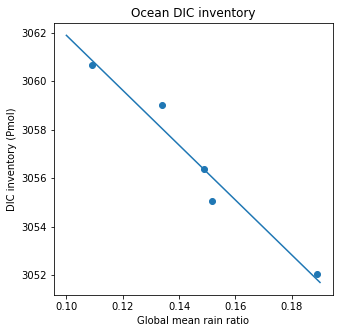

In [57]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Ocean DIC inventory')

ax.scatter(RRs,DICs)
ax.plot(RR_line,DIC_line)
ax.set(ylabel='DIC inventory (Pmol)',xlabel='Global mean rain ratio')